# Employee Attrition Modeling

**Data:** This analysis uses an HR dataset created by IBM data scientists. The data can be found on Kaggle [here](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset).

## Import Libraries

In [164]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("white")
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)  

#Modeling
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE


## Data Preview
We're working with 1470 observations and 35 columns. A review of the data within Kaggle suggests our data is quite clean; but we'll preview the data below.

Initial observations:
* There does not appear to be any missing data or duplicate employee IDs
* All columns appear to have appropriate initial data types
* All numeric columns appear to have reasonable values (no inherently improbably mins/maxs)
* 16% of employees in the dataset turned over (moderate imbalance, unsurprising)
* Other notable attributes:
    * Most employees never travel (71%)
    * Most employees work in R&D (65%) following by Sales (30%)
    * Most employees come from the Life Sciences or Medical fields (73%)
    * 60% of employees are male
    * Mean age = 36.9 years, sd = 9.1
    * Mean tenure = 7.0 years, sd = 6.1

In [2]:
hr_dat = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
hr_dat.shape

(1470, 35)

In [3]:
hr_dat.info()
hr_dat.head()
hr_dat['EmployeeNumber'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


1470

In [4]:
hr_dat.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


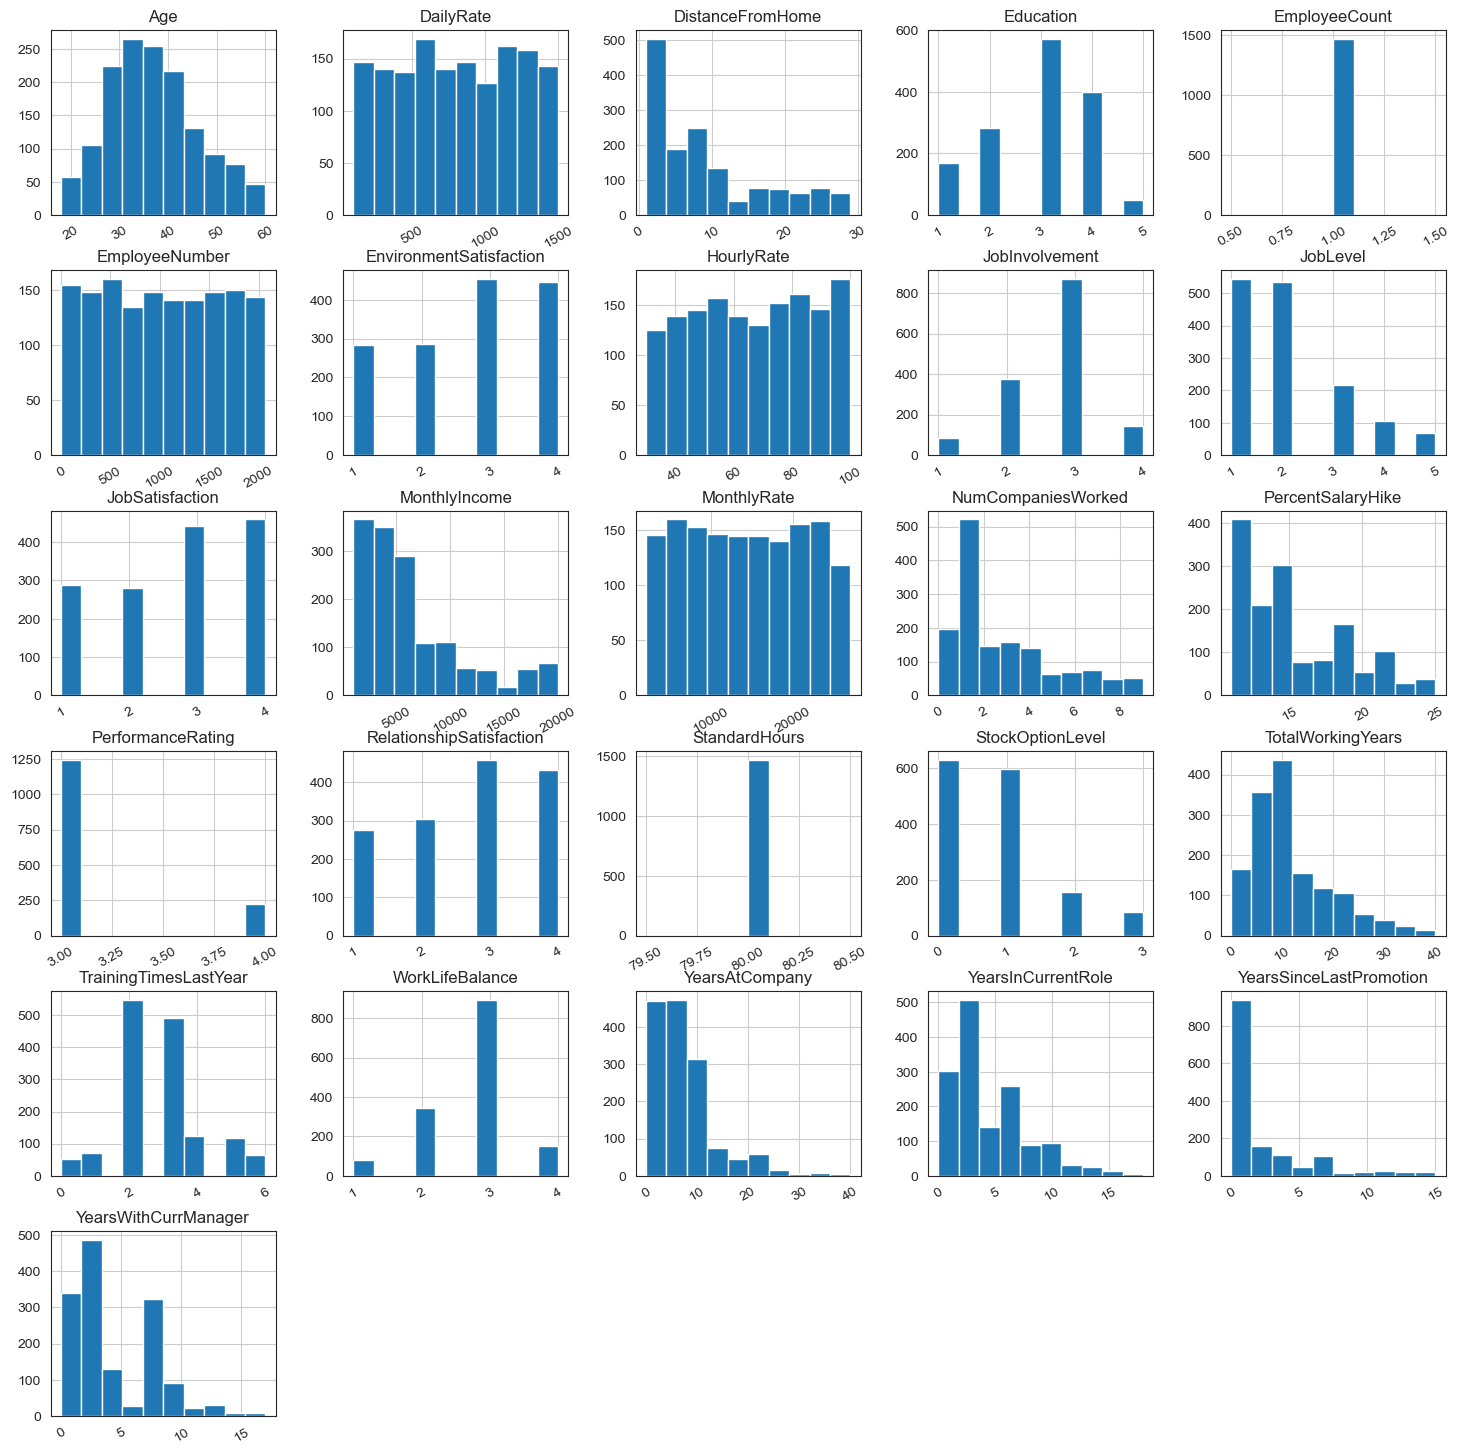

In [5]:
hr_dat.hist(figsize=(18,18), xrot=30)
plt.show();

In [112]:
#review some categorical columns
cat_cols = hr_dat.select_dtypes(include=['object']).columns

for c in cat_cols:
    hr_dat[c].value_counts(normalize = True)
    hr_dat[c].value_counts()

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

No     1233
Yes     237
Name: Attrition, dtype: int64

Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: BusinessTravel, dtype: float64

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: Department, dtype: float64

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: EducationField, dtype: float64

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

Male      0.6
Female    0.4
Name: Gender, dtype: float64

Male      882
Female    588
Name: Gender, dtype: int64

Sales Executive              0.221769
Research Scientist           0.198639
Laboratory Technician        0.176190
Manufacturing Director       0.098639
Healthcare Representative    0.089116
Manager                      0.069388
Sales Representative         0.056463
Research Director            0.054422
Human Resources              0.035374
Name: JobRole, dtype: float64

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

Married     0.457823
Single      0.319728
Divorced    0.222449
Name: MaritalStatus, dtype: float64

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

Y    1.0
Name: Over18, dtype: float64

Y    1470
Name: Over18, dtype: int64

No     0.717007
Yes    0.282993
Name: OverTime, dtype: float64

No     1054
Yes     416
Name: OverTime, dtype: int64

From here, we can drop some unnecessary columns:
* EmployeeCount - All 1s
* EmployeeNumber - Unique identifier
* StandardHours - All 80
* Over18 - All Y

In [8]:
hr_clean = hr_dat.drop(columns=['EmployeeCount','EmployeeNumber','StandardHours', 'Over18'], axis=1)

## Exploratory Data Analysis

In [9]:
#Recode attrition column to 1/0
hr_clean['Attrition'] = hr_clean['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
hr_clean['Attrition'].value_counts(normalize=True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

### Distrubtion of Attrition by Categorical Columns


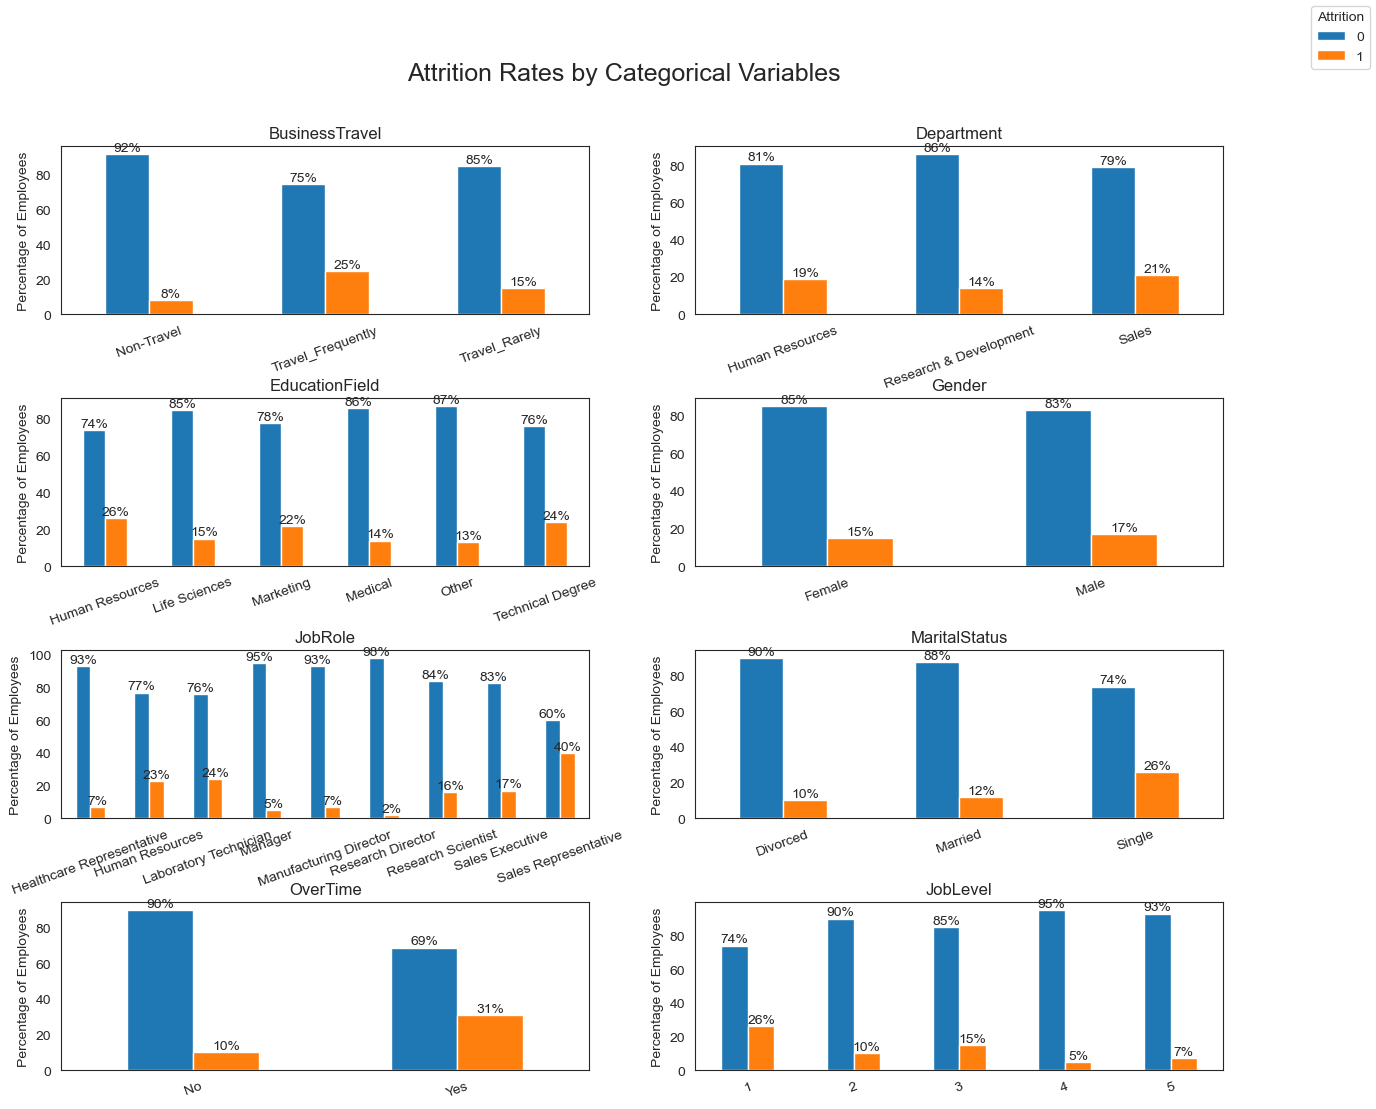

In [10]:
target_cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime', 'JobLevel']

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Attrition Rates by Categorical Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(target_cat_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'Attrition']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='Attrition', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Attrition')

plt.show();

Observations:
* R&D make up the majority of employees, but they have lower attrition than HR and Sales. This trend is further illustrated when viewing attrition by Job Role and Education Field.
    * Overtime and frequent travel do not vary significantly between departments.
* Attrition is similar for males and females.
* Attrition is heightened for employees working overtime, traveling frequently, for single employees, and entry level employees. 

### Distribution of Attrition by Engagement-Related Metrics

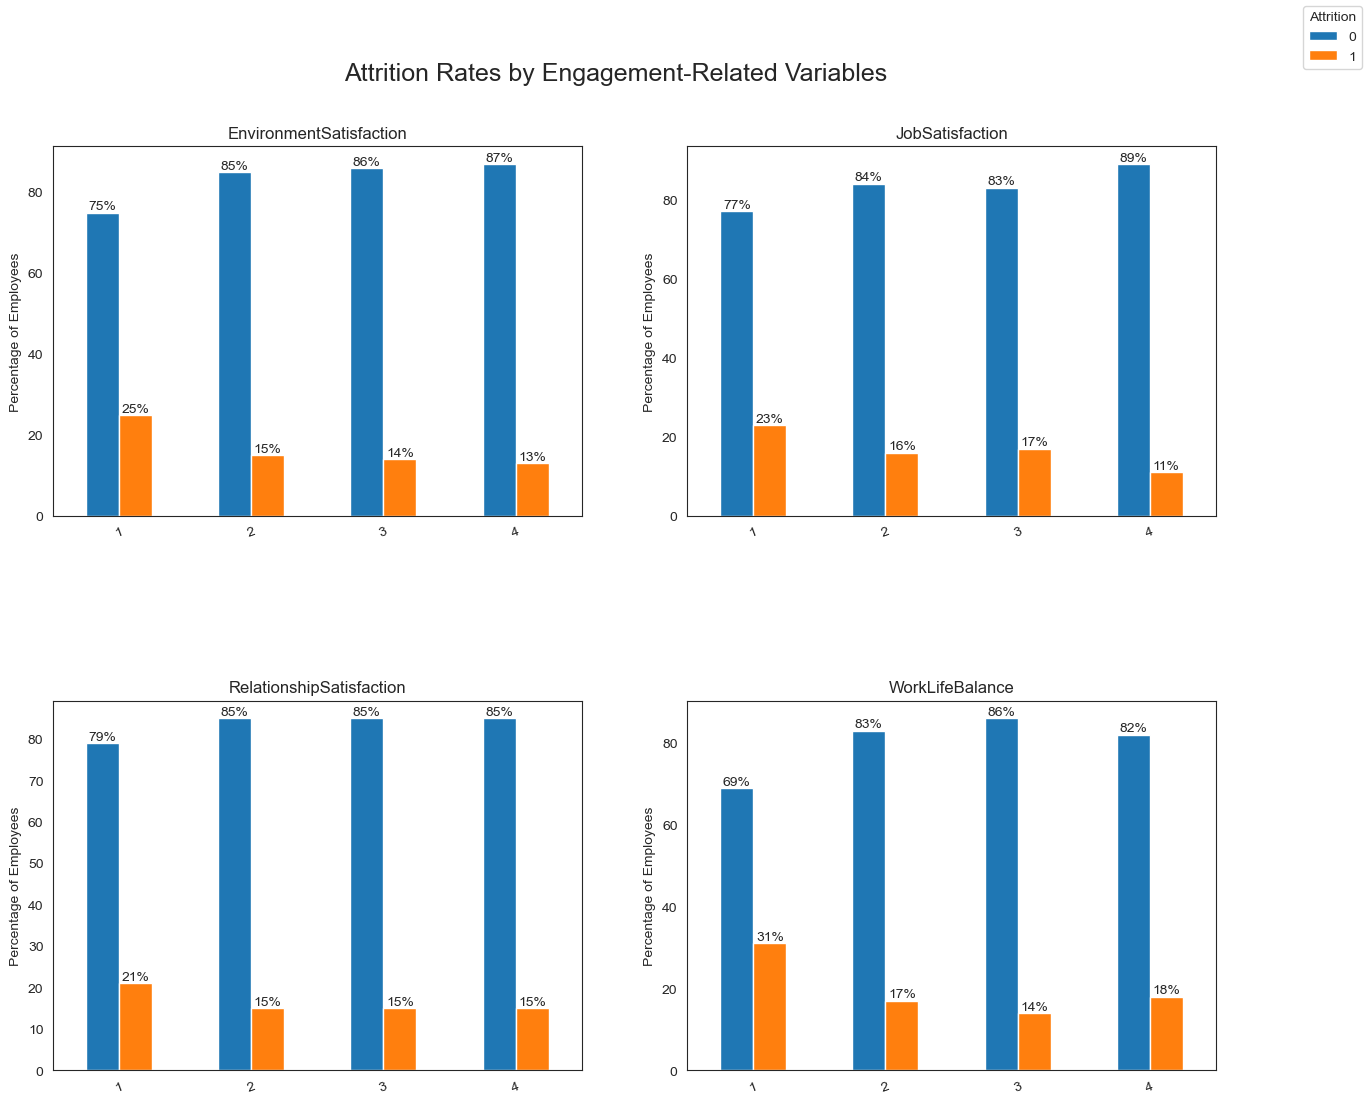

In [11]:
eng_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance']

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Attrition Rates by Engagement-Related Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(eng_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'Attrition']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='Attrition', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Attrition')

plt.show();

* Higher attrition rates as satisfaction decreases, further illustrated by table below.

### Engagement Metrics x Job Role

In [160]:
deptEng = hr_clean.groupby(['Department', 'Attrition'])[['JobSatisfaction','WorkLifeBalance','EnvironmentSatisfaction','RelationshipSatisfaction']].mean().reset_index()
deptEng

,Department,Attrition,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,RelationshipSatisfaction
0,Human Resources,0,2.705882,2.921569,2.764706,2.843137
1,Human Resources,1,2.166667,2.916667,2.333333,3.083333
2,Research & Development,0,2.769324,2.748792,2.787440,2.739130
3,Research & Development,1,2.458647,2.578947,2.473684,2.518797
4,Sales,0,2.810734,2.836158,2.734463,2.706215
5,Sales,1,2.521739,2.739130,2.467391,2.652174


### Correlation Matrix


In [162]:
#Create dummy variables
hr_dummies = hr_clean.copy()
hr_dummies['Gender'] = hr_dummies['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
hr_dummies['OverTime'] = hr_dummies['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)
hr_dummies['BusinessTravel'] = hr_dummies['BusinessTravel'].apply(lambda x: 0 if x == 'Non-Travel' else
                                                                  1 if x == 'Travel_Rarely' else 3 )

#Grab dummies for cat vars of interest - mostly just dropping perf rating bc it has virtually no variance
hr_dummies = pd.get_dummies(hr_dummies, columns=['Department', 'MaritalStatus', 'JobRole', 'EducationField'], drop_first=True)

hr_dummies.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,MaritalStatus_Married,MaritalStatus_Single,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
0,41,1,1,1102,1,2,2,0,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,49,0,3,279,8,1,3,1,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,37,1,1,1373,2,2,4,1,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,33,0,3,1392,3,4,4,0,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,27,0,1,591,2,1,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


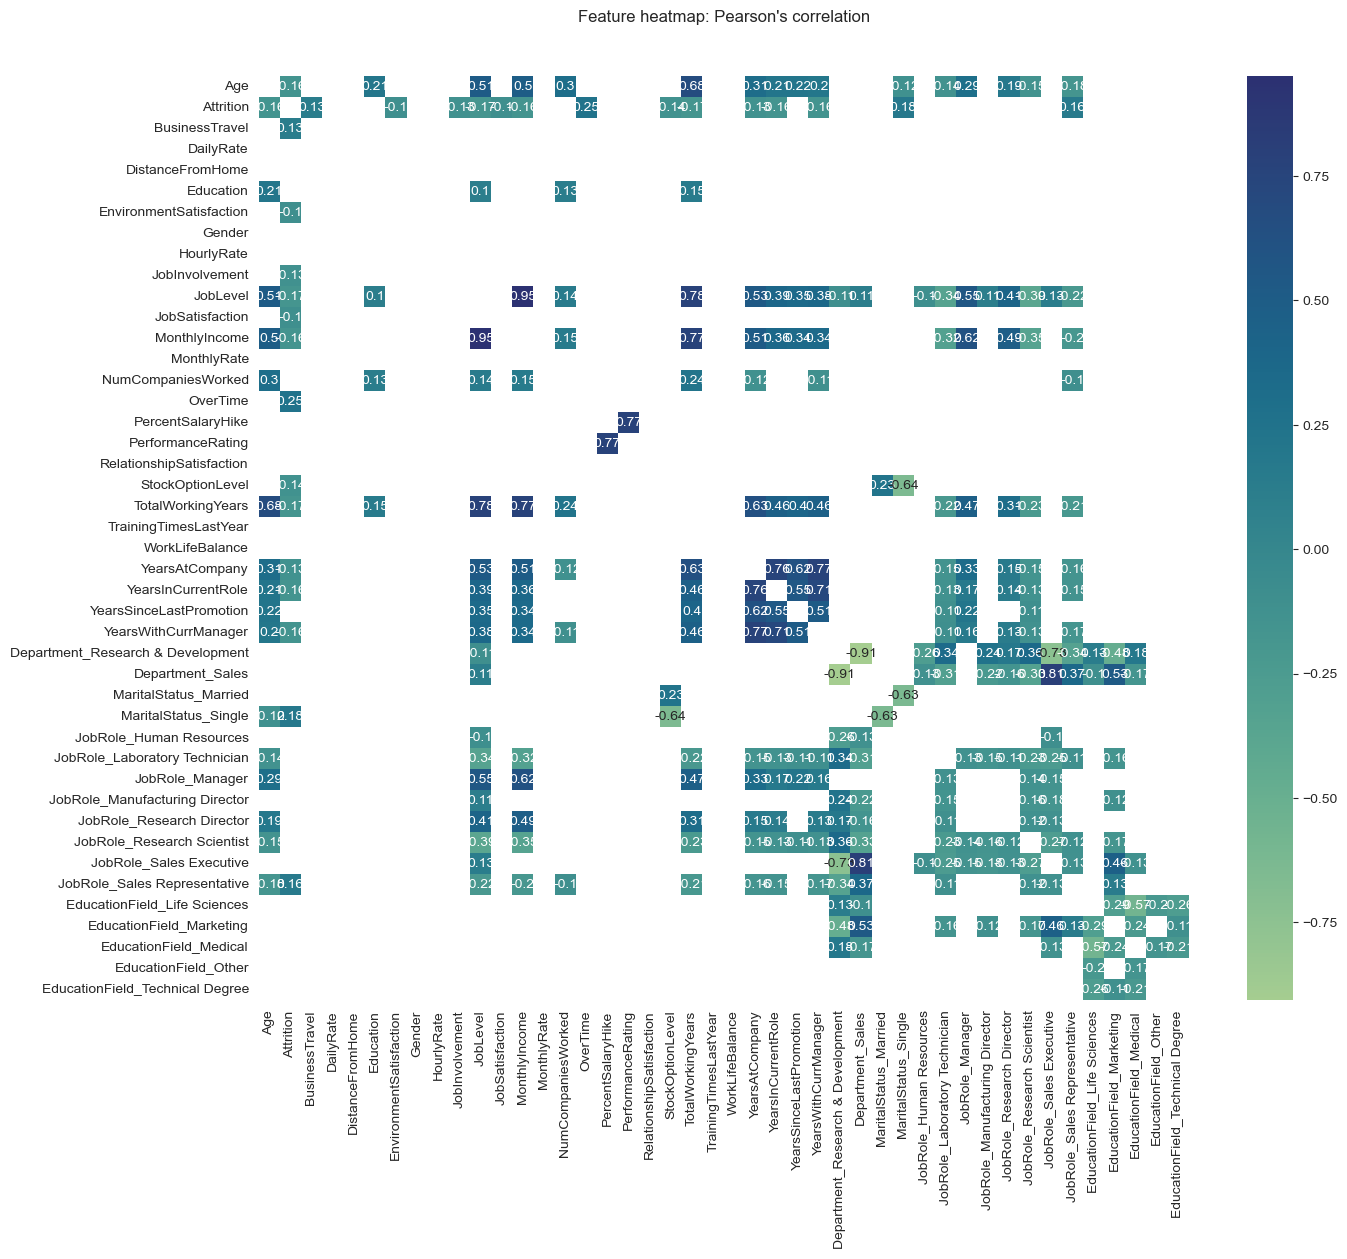

In [14]:
#create pearson correlation heatmap of features
corrs = hr_dummies.corr()

#only show corrs between .2 and 1 for readability (corr = 1 is just self correlation)
plt.figure(figsize=(15,12))
sns.heatmap(corrs[((corrs>0.1)&(corrs<1)) | (corrs < -.1)], cmap='crest', annot=True)
plt.title("Feature heatmap: Pearson's correlation", y = 1.05);

Let's get a better view of what correlates with attrition.

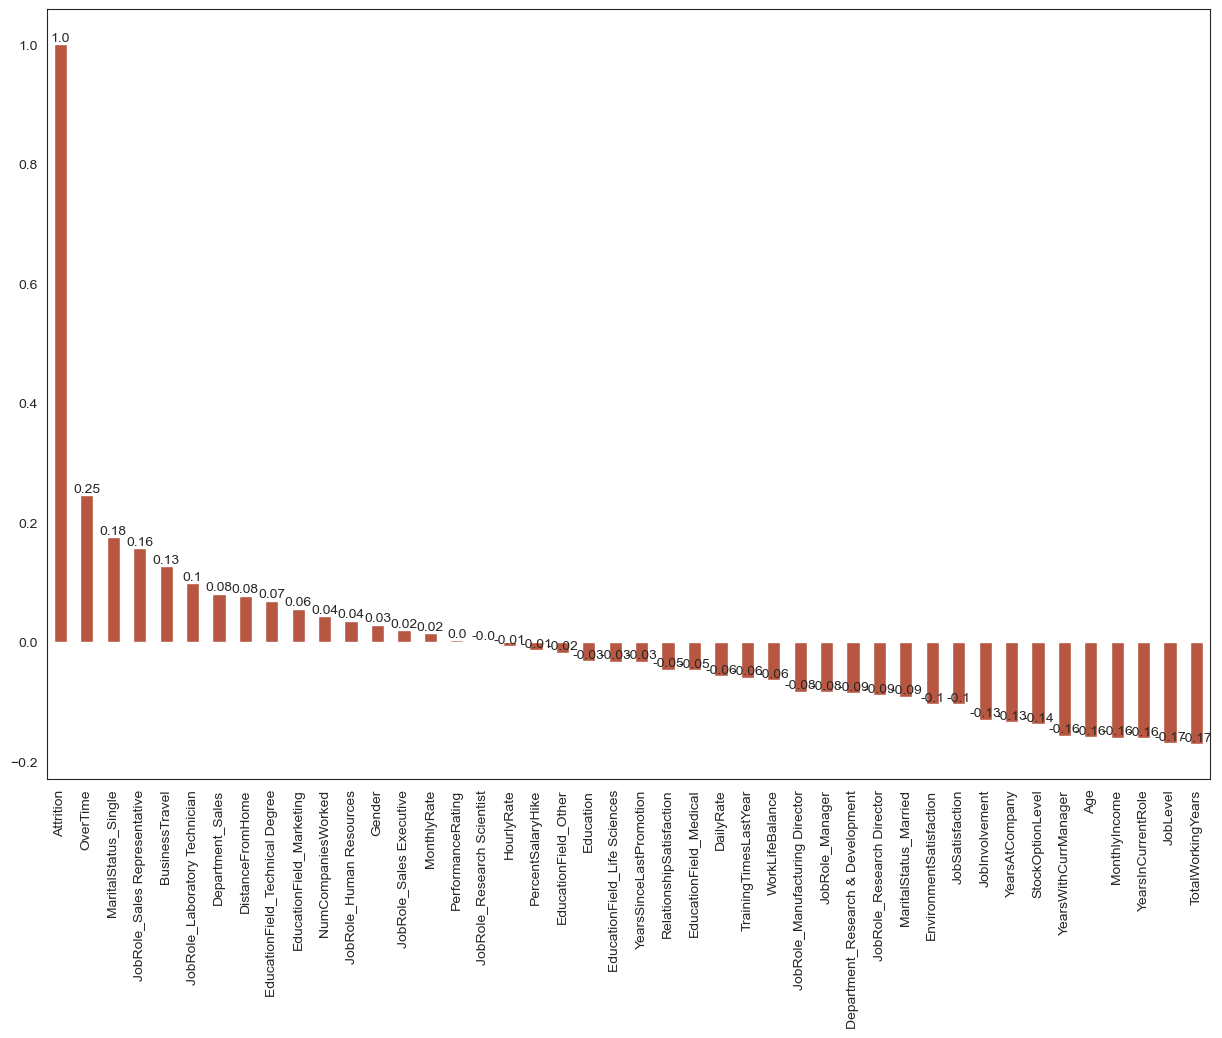

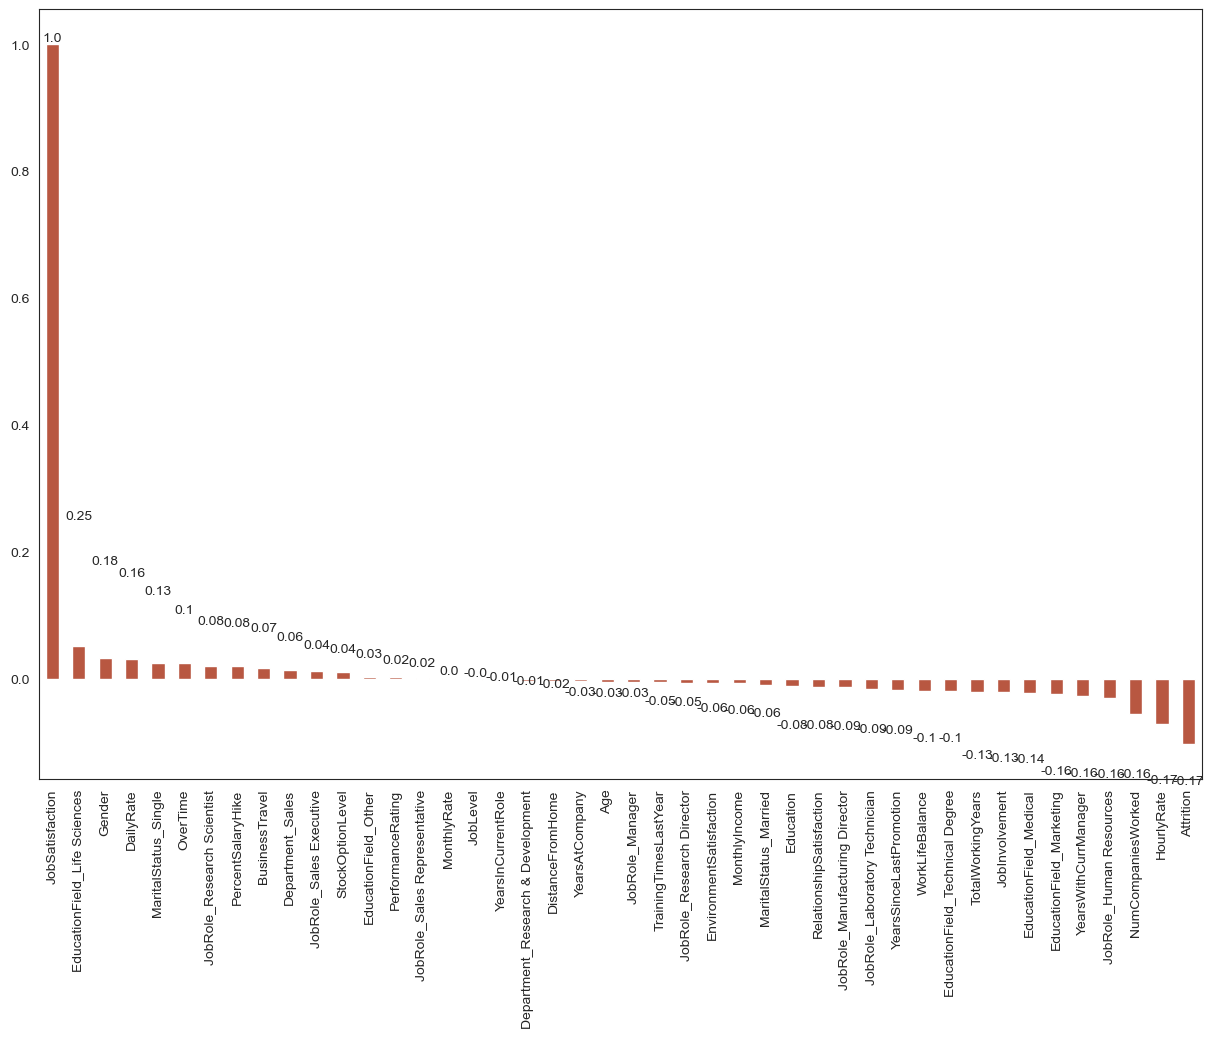

In [119]:
plt.figure(figsize=(15,10))
corplot = corrs['Attrition'].sort_values(ascending = False).plot(kind='bar')
# Add labels to the bars
for i, val in enumerate(corrs['Attrition'].sort_values(ascending=False)):
    corplot.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontsize': 10})
plt.show();

plt.figure(figsize=(15,10))



## Feature Selection
Currently, our model could have up to 47 features! To avoid over-fitting the model, I'd like to reduce this number. Here are my guiding principles using the data preview, EDA, and domain knowledge:
1. Include job engagement related features - This are can be insightful, actionable, and research suggests these may drive attrition. Keep:
* RelationshipSatisfaction
* EnvironmentSatisfaction
* WorkLifeBalance
* JobSatisfaction

2a. Remove features w/ < .05 correlation with attrition. 
2b. Eliminate features that are highly inter-correlated. Inter-correlated features will not add enough incremental uniqueness or value to the model. Through EDA and reviewing inter-correlations, I'll select features I think will be most insightful and strike through the eliminated features.
* OverTime
* MaritalStatusSingle
* BusinessTravel
* JobRoleLabTech
* ~~DepartmentSales~~
* DistanceFromHome
* EducationFieldTechnical.Degree
* EducationFieldMarketing
* ~~TotalWorkingYears~~
* JobLevel
* ~~YearsInCurrentRole~~
* MonthlyIncome
* Age
* ~~YearsWithCurrManager~~
* StockOptionLevel
* YearsAtCompany
* MaritalStatusMarried
* JobRoleResearch.Director
* MaritalStatusDivorced
* ~~DeparmentResearchAndDev~~
* JobRoleManager
* JobRoleManufacturingDirector
* JobRoleHealthcare.Rep
* TrainingTimesLastYear

Final List:
* RelationshipSatisfaction
* EnvironmentSatisfaction
* WorkLifeBalance
* JobSatisfaction
* OverTime
* MaritalStatusSingle
* BusinessTravel
* JobRoleLabTech
* DistanceFromHome
* EducationFieldTechnical.Degree
* EducationFieldMarketing
* JobLevel
* MonthlyIncome
* Age
* StockOptionLevel
* YearsAtCompany
* MaritalStatusMarried
* JobRoleResearch.Director
* JobRoleManager
* JobRoleManufacturingDirector
* TrainingTimesLastYear




In [161]:
hr_final = hr_dummies[['Attrition', 
                       'RelationshipSatisfaction',
                       'EnvironmentSatisfaction',
                       'WorkLifeBalance',
                       'JobSatisfaction',
                       'OverTime',
                       'MaritalStatus_Single',
                       'BusinessTravel',
                       'JobRole_Laboratory Technician',
                       'DistanceFromHome',
                       'EducationField_Technical Degree',
                       'EducationField_Marketing',
                       'JobLevel',
                       'MonthlyIncome',
                       'Age',
                       'StockOptionLevel',
                       'YearsAtCompany',
                       'MaritalStatus_Married',
                       'JobRole_Research Director',
                       'JobRole_Manager',
                       'JobRole_Manufacturing Director',
                       'TrainingTimesLastYear']]

In [45]:
hr_final.head()

,Attrition,RelationshipSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,JobSatisfaction,OverTime,MaritalStatus_Single,BusinessTravel,JobRole_Laboratory Technician,DistanceFromHome,EducationField_Technical Degree,EducationField_Marketing,JobLevel,MonthlyIncome,Age,StockOptionLevel,YearsAtCompany,MaritalStatus_Married,JobRole_Research Director,JobRole_Manager,JobRole_Manufacturing Director,TrainingTimesLastYear
0,1,1,2,1,4,1,1,1,0,1,0,0,2,5993,41,0,6,0,0,0,0,0
1,0,4,3,3,2,0,0,3,0,8,0,0,2,5130,49,1,10,1,0,0,0,3
2,1,2,4,3,3,1,1,1,1,2,0,0,1,2090,37,0,0,0,0,0,0,3
3,0,3,4,3,3,1,0,3,0,3,0,0,1,2909,33,0,8,1,0,0,0,3
4,0,4,1,3,2,0,0,1,1,2,0,0,1,3468,27,1,2,1,0,0,0,3


## Data Modeling

Let's start with a regression model.
Due to class imbalance, I'll do the following:
* Logistic regression with an L1 penalty (Lasso - help reduce complexity and optimize performance)
* K-folds cross-validation to evaluate performance/reliable against different subsets (folds) of the data
* 80/20 split to fit the model and make test predictions. Review strongest features as sources of attrition drivers.

##### K-Folds Cross Validation

In [1]:
# Define cross validation function
def kfold_cv(model, X, y, splits = 10, repeats = 3):
    # Set up repeated kfolds for cross validation
    # By default, data will be split into ten folds that will each be used as training and testing sets to evaluate reliability
    # (and this is repeated 3 times), making us more confident in the generalizability of the model
    cv = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=42)

    # set up scorer
    # selecting some standard evaluation measures to give an overview of model performance
    scoring = {
        'accuracy': make_scorer(accuracy_score), # What % of predictions was the model correct on?
        'sensitivity': make_scorer(recall_score), # aka recall or true positive rate; What % correctly identified as turnover?
                                                # true positive / all actual positive
        'specificity': make_scorer(recall_score,pos_label=0), # aka true negative rate; What % correctly idetified as stayer?
                                                            # true negative / all actual negative
        'precision': make_scorer(precision_score), # aka positive predictive value; of all predicted as leavers, what % were correct?
                                                # true positive / all pred. positive
        'AUC': make_scorer(roc_auc_score), # area under ROC curve; ROC plots illustratess trade off between true pos rate and false pos rate
                                            # higher value under this curve represents lower trade off/better performing model
                }
    
    #Cross validate and report performance
    scores = cross_validate(model, X, y, scoring= scoring, cv=cv, n_jobs=-1)

    #report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
    print('Sensitivity: %.3f (%.3f)' % (np.mean(scores['test_sensitivity']), np.std(scores['test_sensitivity'])))
    print('Specificity: %.3f (%.3f)' % (np.mean(scores['test_specificity']), np.std(scores['test_specificity'])))
    print('Precision: %.3f (%.3f)' % (np.mean(scores['test_precision']), np.std(scores['test_precision'])))
    print('AUC: %.3f (%.3f)' % (np.mean(scores['test_AUC']), np.std(scores['test_AUC'])))

In [200]:
# set up training and testing sets
X = hr_final.drop('Attrition', axis = 1)
y = hr_final['Attrition']

#80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# confirm imbalnance
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

# create Logistic Regression model
att_model = LogisticRegression(solver = 'liblinear', # useful for datasets < 10k
                                   penalty='l1') # lasso penalty that optimizes for model simplicity while optimizing performance

# cross validate
kfold_cv(att_model, X_train, y_train)



(1176, 21)
(294, 21)
(1176,)
(294,)


0    0.831633
1    0.168367
Name: Attrition, dtype: float64

0    0.867347
1    0.132653
Name: Attrition, dtype: float64

Accuracy: 0.870 (0.024)
Sensitivity: 0.348 (0.112)
Specificity: 0.975 (0.014)
Precision: 0.728 (0.192)
AUC: 0.662 (0.055)


* Our accuracy is quite high, so our model is correct most of the time; however, this comes at the expense of sensitivity. Our model is conservative with classifying employees as leavers. This is unsurprising given the imbalanced nature of the data. Given this validation, I expect to see similar results upon prediction below.

##### Make Predictions on Test Set and Evaluate

In [175]:
#fit on training data
att_model.fit(X_train, y_train)
#predict
att_log_pred = att_model.predict(X_test)



LogisticRegression(penalty='l1', solver='liblinear')

In [167]:
#create model
att_log_model = LogisticRegression(solver = 'liblinear',
                                   penalty='l1') #Lasso regression to decrease complexity, optimize performance

#fit model on training data
att_log_model.fit(X_train, y_train)

#predict
att_log_pred = att_log_model.predict(X_test)


LogisticRegression(penalty='l1', solver='liblinear')

In [192]:
#Define function for evaluating our model
def eval_model(predictions, actual):
    #Evaluate model
    #print confusion matrix
    cf = pd.DataFrame(confusion_matrix(y_true = actual, y_pred = predictions))

    # calculate scores from confusion matrix values
    t_neg, f_pos, f_neg, t_pos = confusion_matrix(y_true = actual, y_pred = predictions).ravel()

    #accuracy
    acc = accuracy_score(y_true = actual, y_pred = predictions)
    print(acc)
    #sensitivity
    sens = recall_score(y_true = actual, y_pred = predictions)
    #specifiction
    spec = t_neg / (t_neg+f_pos)
    #precision
    prec = precision_score(y_true = actual, y_pred = predictions)
    #ROC AUC
    auc = roc_auc_score(y_true = actual, y_score = predictions)

    #report performance
    print('Confusion Matrix:')
    print(cf)
    print('Accuracy: %.3f' % (acc))
    print('Sensitivity: %.3f' % (sens))
    print('Specificty: %.3f' % (spec))
    print('Precision: %.3f' % (spec))
    print('AUC: %.3f' % (auc))
    

In [193]:
#Evaluate model
eval_model(att_log_pred, y_test)

0.8843537414965986
Confusion Matrix:
     0   1
0  248   7
1   27  12
Accuracy: 0.884
Sensitivity: 0.308
Specificty: 0.973
Precision: 0.973
AUC: 0.640


* As expected, the model performed similarly with our test data.
* Before moving on, let's look into feature performance to see what it driving attrition.

In [196]:
# Function to return features and log odds (exponentiated coefficients)
# This tell us for each feature, if holding all other constant, how does its presence increase/decrease
# the liklihood of turnover; above 1 OR means odds of turnover are increases; opposite for below 1
def get_or(model, X):
    print(f"Model Intercept (Exponentiated): {np.exp(model.intercept_)}")

    features = pd.DataFrame(X.columns)
    odds_r = pd.DataFrame(np.exp(model.coef_))
    odds_r = odds_r.melt(var_name ='num', value_name='odds ratio')

    log_odds = pd.concat([features, odds_r], axis =1)
    log_odds.drop('num', axis = 1, inplace=True)
    log_odds = log_odds.sort_values(by = 'odds ratio', ascending = False)
    print(log_odds)
    

In [199]:
#Get feature importance
get_or(att_log_model, X_train)

Model Intercept (Exponentiated): [0.11044576]
                                  0  odds ratio
4                          OverTime    2.258452
5              MaritalStatus_Single    1.667257
6                    BusinessTravel    1.492344
9   EducationField_Technical Degree    1.279357
7     JobRole_Laboratory Technician    1.266109
8                  DistanceFromHome    1.261036
10         EducationField_Marketing    1.204854
16            MaritalStatus_Married    1.116527
12                    MonthlyIncome    1.000000
18                  JobRole_Manager    0.975804
0          RelationshipSatisfaction    0.917528
14                 StockOptionLevel    0.859599
20            TrainingTimesLastYear    0.854466
2                   WorkLifeBalance    0.842897
19   JobRole_Manufacturing Director    0.831805
11                         JobLevel    0.827257
15                   YearsAtCompany    0.819751
13                              Age    0.788888
17        JobRole_Research Director    0.7

Notable feature include overtime, job satisfaction, business travel, and environment satisfaction. Labs techs also seem to have more turnover while Research Directors have less turnover. 

This model gives us some insight on what might be driving attrition, however, its low sensitivity makes it less practical for usage for identifying actual exits. To try to improve sensitivity, next steps could include the following.
1. Manually lower our threshold for predicting attrition to below .5. This would cause our model to classify someone as an exit more often. However, this would inflate our false positive rate. This has pros and cons depending upon how this model is leveraged in the business.
2. Using a resampling technique to balance the data 
3. Try out an ensemble technique (AdaBoost, Bagging, etc.) or other techniques that better handle imbalance (XGBoost)

For the purposes of this case study, I'll choose one path to explore: resampling. I'm choosing resampling because I would like to stick with the interpretability of logistic regression modeling in this context.

#### Resampling Approach: SMOTE
SMOTE selects random neighbors of random minority class members and then creates a new observation of the minority class based on the features between the neighbor and the random class member; this is done repeatedly until imbalance is resolved. I will not be applying smote to the test set, as I want this to accurately represent actual org data.

In [205]:
#Use SMOTE to oversample our minority class (attrition) to address class imbalance
# SMOTE selects random neighbors of random minority class members and then creates a new observation of the minority
# class based on the features between the neighbor and the random class member; this is done repeatedly until imbalance is resolved
# I will not be applying smote to the test set, as I want this to accurately represent actual org data
X_train_sm, y_train_sm = SMOTE(sampling_strategy=1, random_state = 42).fit_resample(X_train, y_train)
print(X_train_sm.shape)
print(y_train_sm.shape)
y_train_sm.value_counts(normalize=True)

# smote model
sm_model = LogisticRegression(solver = 'liblinear', # useful for datasets < 10k
                                   penalty='l1') # lasso penalty that optimizes for model simplicity while optimizing performance

# cross validate
kfold_cv(sm_model, X_train_sm, y_train_sm)


(1956, 21)
(1956,)


0    0.5
1    0.5
Name: Attrition, dtype: float64

Accuracy: 0.763 (0.029)
Sensitivity: 0.774 (0.042)
Specificity: 0.754 (0.040)
Precision: 0.758 (0.047)
AUC: 0.764 (0.029)


In [206]:
#fit model on training data
sm_model.fit(X_train_sm, y_train_sm)

#predict
sm_log_pred = sm_model.predict(X_test)

LogisticRegression(penalty='l1', solver='liblinear')

In [211]:
#Evaluate model
eval_model(sm_log_pred, y_test)

0.7346938775510204
Confusion Matrix:
     0   1
0  191  64
1   14  25
Accuracy: 0.735
Sensitivity: 0.641
Specificty: 0.749
Precision: 0.749
AUC: 0.695


Our AUC shows that our SMOTE model performs slightly better than our imbalanced model. While accuracy and specificity have taken a hit, our sensitivity has around doubled, which was our goal! For the purposes of this case study, this model would be more helpful in a situation where we are focused on identifying attrition risk and are ok with have more false positives. For the purpose of discussing attrition drivers, I may choose to utilize the imbalanced model since it is a direct representation of the actual employee population, though the feature importance below generally mirrors the original model.

In [210]:
#Get feature importance
get_or(sm_model, X_train)

Model Intercept (Exponentiated): [0.49411871]
                                  0  odds ratio
4                          OverTime    2.386052
5              MaritalStatus_Single    1.798379
12                    MonthlyIncome    1.575594
6                    BusinessTravel    1.394857
16            MaritalStatus_Married    1.278736
8                  DistanceFromHome    1.195822
9   EducationField_Technical Degree    1.181266
7     JobRole_Laboratory Technician    1.163792
10         EducationField_Marketing    1.092227
0          RelationshipSatisfaction    1.000000
15                   YearsAtCompany    0.948604
14                 StockOptionLevel    0.833567
20            TrainingTimesLastYear    0.832196
2                   WorkLifeBalance    0.796310
13                              Age    0.759481
19   JobRole_Manufacturing Director    0.740978
1           EnvironmentSatisfaction    0.713343
3                   JobSatisfaction    0.693713
11                         JobLevel    0.6

#### Closer Look: Over Time

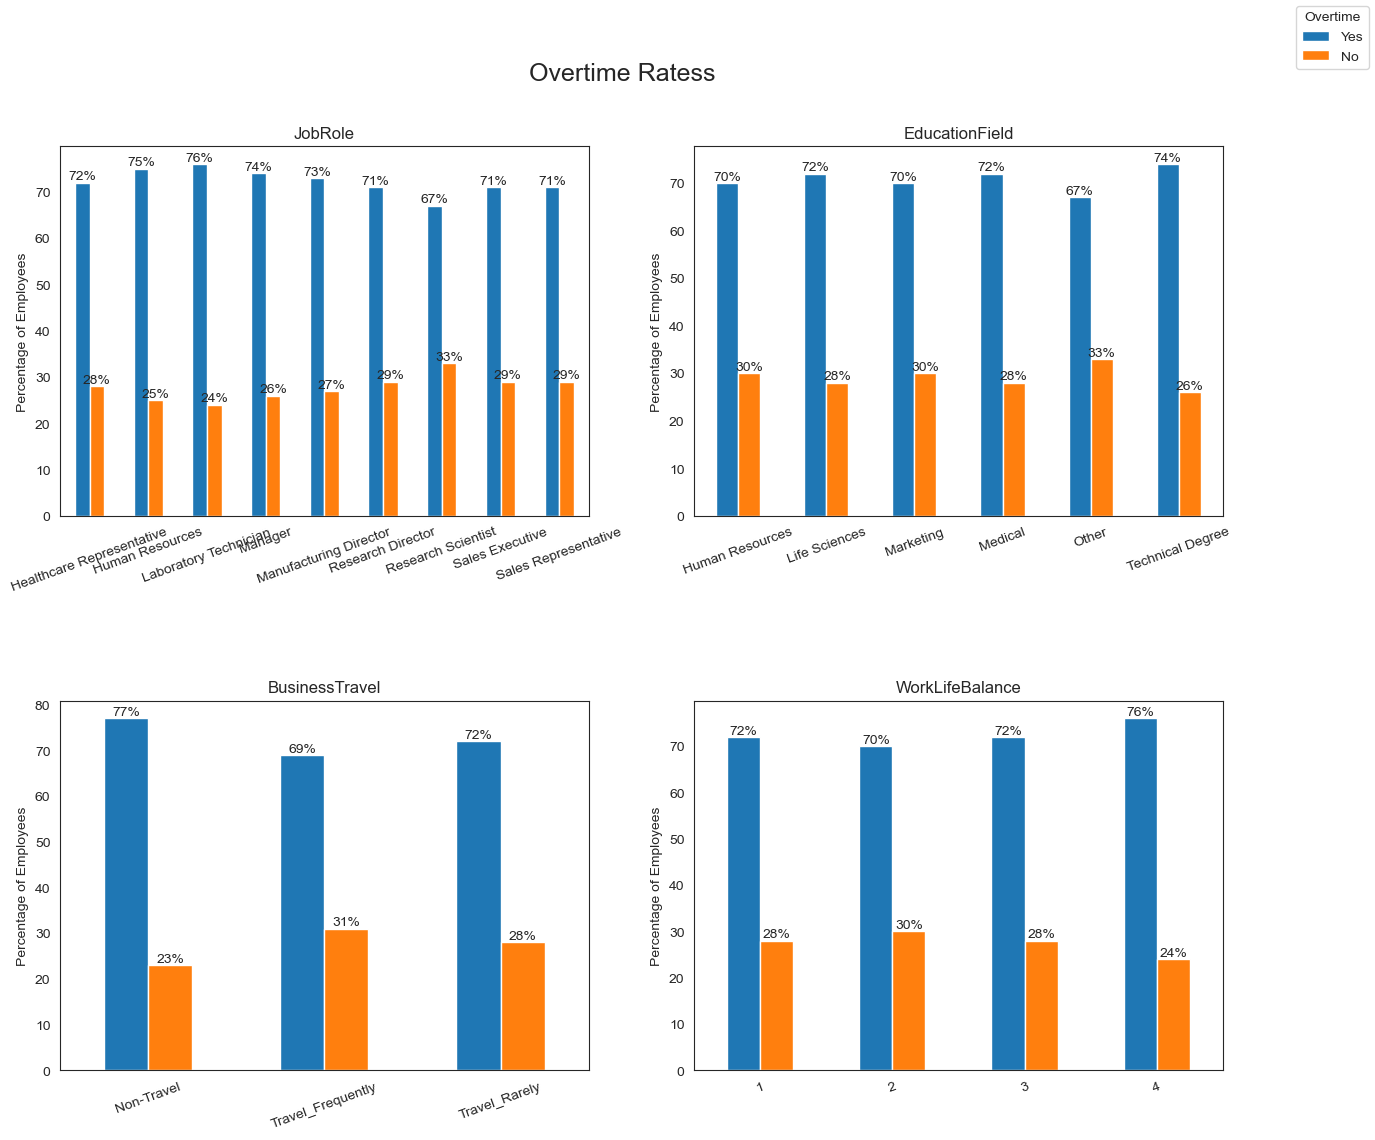

In [111]:
ot_cols = ['JobRole', 'EducationField', 'BusinessTravel', 'WorkLifeBalance']

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Overtime Ratess", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(ot_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'OverTime']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='OverTime', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Overtime')

plt.show();

In [113]:
otEng = hr_clean.groupby(['Attrition'])[['JobSatisfaction','WorkLifeBalance','EnvironmentSatisfaction','RelationshipSatisfaction']].mean().reset_index()
otEng

,Attrition,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,RelationshipSatisfaction
0,0,2.778589,2.781022,2.771290,2.733982
1,1,2.468354,2.658228,2.464135,2.599156


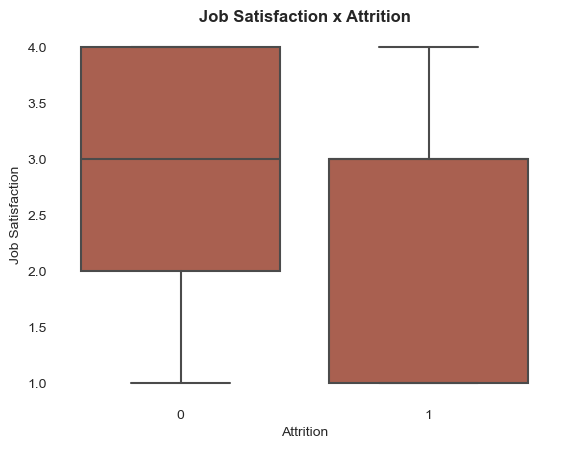

In [118]:
#JobSat x Attrition
sns.set_palette(["#b85741", "#b85741"])
ax = sns.boxplot(data= hr_clean, x = "Attrition", y = "JobSatisfaction")
plt.title('Job Satisfaction x Attrition', weight= 'bold')
ax.set_ylabel('Job Satisfaction')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show();




#### What's driving Job Satisfaction?
Given the lack of employee experience/engagement data in the data set, we're a bit limited in how we can determine job satisfaction drivers. Since Job Satisfaction is on an ordinal scale from 1-4, we'll run an ordinal logistic regression to see if we can identify some drivers.

Overall, we aren't seeing significant results, which is unsurprising given the scale of the data we have (range restriction, unclear validity of the measure, lack of measurement of other drivers of job satisfaction). Given Job Satisfaction is a driver of attrition, and we have other drivers of attrition related to other employee demographics (age, tenure, income, job type), I think we have a case to partner with the employee listening team and see how their holistic engagement measure may reveal patterns amongst these employee demographics.

In [212]:
model = OrderedModel(hr_dummies['JobSatisfaction'], hr_dummies[[
                                                           'RelationshipSatisfaction',
                                                           'JobInvolvement',
                                                           'WorkLifeBalance',
                                                           'BusinessTravel',
                                                           'JobRole_Research Director',
                                                           'JobRole_Manager',
                                                           'JobRole_Laboratory Technician',
                                                           'Age',
                                                           'MonthlyIncome'
                                                           
                                                           ]])

res_prob = model.fit(method = 'bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.359486
         Iterations: 38
         Function evaluations: 43
         Gradient evaluations: 43


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        JobSatisfaction   Log-Likelihood:                -1998.4
Model:                   OrderedModel   AIC:                             4021.
Method:            Maximum Likelihood   BIC:                             4084.
Date:                Fri, 19 May 2023                                         
Time:                        13:20:03                                         
No. Observations:                1470                                         
Df Residuals:                    1458                                         
Df Model:                          12                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
RelationshipSatisfaction         -0.0106      0.026     -0.407      0.684      -0.062       0.041
JobInvolvement                   -0.0346      0.040     -0.864      0.387      -0.113       0.044
WorkLifeBalance                  -0.0338      0.040     -0.843      0.399      -0.112       0.045
BusinessTravel                    0.0237      0.032      0.738      0.460      -0.039       0.086
JobRole_Research Director        -0.0115      0.171     -0.067      0.946      -0.346       0.323
JobRole_Manager                   0.0148      0.170      0.087      0.931      -0.319       0.349
JobRole_Laboratory Technician    -0.0579      0.079     -0.729      0.466      -0.214       0.098
Age                              -0.0002      0.004     -0.066      0.947      -0.007       0.007
MonthlyIncome                 -2.825e-06   1.17e-05     -0.241      0.810   -2.58e-05    2.02e-05
1/2                              -1.0782      0.216     -4.994      0.000      -1.501      -0.655
2/3                              -0.5667      0.055    -10.395      0.000      -0.674      -0.460
3/4                              -0.2519      0.042     -6.026      0.000      -0.334      -0.170
=================================================================================================
"""

In [147]:
hr_clean.groupby(['JobRole'])[['JobSatisfaction','WorkLifeBalance','EnvironmentSatisfaction','RelationshipSatisfaction']].mean().reset_index()


,JobRole,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,RelationshipSatisfaction
0,Healthcare Representative,2.786260,2.702290,2.770992,2.694656
1,Human Resources,2.557692,2.923077,2.596154,2.961538
2,Laboratory Technician,2.691120,2.718147,2.718147,2.687259
3,Manager,2.705882,2.774510,2.764706,2.813725
4,Manufacturing Director,2.682759,2.765517,2.917241,2.724138
5,Research Director,2.700000,2.862500,2.500000,2.687500
6,Research Scientist,2.773973,2.678082,2.726027,2.705479
7,Sales Executive,2.754601,2.803681,2.671779,2.702454
8,Sales Representative,2.734940,2.891566,2.734940,2.602410
